Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [45]:
# Your name here
NAME = "Daniel Kim"
# list collaborators separated by commas
COLLABORATORS = ""

In [46]:
## Adding a check for version
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# Assignment 4: Greedy (Hill-Climbing)  and Simulated Annealing Search for Sudoku


In this assignment we will explore various heuristic search algorithms for solving Sudoku as an optimization problem. This assignment will reuse ideas and concepts from the previous assignment (Assignment # 2) focussing on Sudoku. However, we will build the data structures differently to ensure easy programming of the search algorithms to be considered.

## Assignment at a Glance

  - Problem 1: Implement the function `compute_fitness_score` as described below.
  - Problem 2: Implement Hill Climbing Search.
    - Implement functions: `hill_climbing_single_step(board)` and `hill_climb_until_local_max(starting_board)`
  - Problem 3: 
    - Complete Implementation Of Basic Simulated Annealer by implementing the function `simulated_annealing_single_step(current_state, current_temperature)`.
    - Run simulated annealing on some problems and report on your experiences


## Problem 1 : Implement a Fitness Function

In this part, we ask you to complete a fitness function and some other associated utility functions. 

First, we will describe the modified Sudoku problem data structure.

### SudokuBoard Python Class

The sudoku board has the following fields, please read carefully.

  - `self.prefills` : a dictionary mapping cell coordinates `(i,j)` to the initial value `k` that was present in the __original__ problem instance. Cells that are originally blank are not part of the dictionary. 
  - `self.allowed_entries`: a dictionary mapping cell coordinates `(i,j)` to a __list of all possible values__ `k` that can possible be at cell `(i,j)` without causing a repeated entry given the prefills in row `i`, column `j` or block corresponding to cell `(i,j)`.
    - Note: that prefilled coordinates `(i,j)` are present in this dictionary and simply mapped to a singleton list `k`.
    - Also note that the dictionary contains a non-empty list for each `(i,j)` with `1 <= i <= 9` and `1 <= j <= 9`.
    - Function: `self.compute_allowed_entries_for_cell( i, j)` is called by the constructor to populate this dictionary. Please examine the code.
  - `self.state`: A dictionary that maps each `(i,j)` to some value `k`. However, it need not be __valid__. That is there may be repeated entries in some rows, columns or blocks.
    - Important Property 1: If `self.state[(i,j)] = k` then `k` must be an element of `self.allowed_entries[(i,j)]`.
    - Important Property 2: `self.state` has an entry for each `(i,j)` with `1 <= i <= 9` and `1 <= j <= 9`.
    - Function: `self.initialize_state` initializes `self.state` to a random initial state. Examine and understand the code for this function.
  
## Implement Fitness Function (10 points)

You will first implement `self.compute_fitness_score` function below that computes a numerical score of how "fit" the current state `self.state` is. 
  - For each row from 1 to 9, 
    - compute how many __unique entries__ row has. I.e collect all numbers in row and count how many unique numbers are in the row. 
    - Subtract 9 from the number of __unique entries__ and add result to the overall fitness.
  - For each col from 1 to 9
    - compute how many __unique entries__ col has. 
    - Subtract 9 from the number of __unique entries__ and add result to the overall fitness.
  - For each blk from (1,1) to (3,3)
    - compute how many __unique entries__ blk has. 
    - Subtract 9 from the number of __unique entries__ and add result to the overall fitness.
  
If the Sudoku is solved, the fitness function is zero since each row, column and block have 9 unique entries. 
Otherwise, the fitness function is negative since, for example,  if a row has `5` unique entries (i.e, there are 4 repetitions), its contribution to the fitness function is `5-9 = -4`.

___Trick___: given a list of numbers `lst` from 1 - 9, you can compute the number of unique entries in `lst` by simply converting `lst` to a set and returning the size of the set.

~~~
return len(set(lst))
~~~

#### Fitness Function (Example)

Sudoku Board: 

~~~
|---------+---------+---------|
| 9  2  2 | 2  3  6 | 6  1  4 |
| 8  6  3 | 2  1  2 | 7  9  2 |
| 7  7  9 | 6  2  2 | 3  8  8 |
|---------+---------+---------|
| 2  7  8 | 4  7  9 | 1  5  3 |
| 5  7  1 | 4  6  3 | 9  9  8 |
| 3  4  6 | 5  8  7 | 6  2  7 |
|---------+---------+---------|
| 3  5  2 | 8  4  7 | 2  6  1 |
| 3  1  4 | 8  7  5 | 8  9  7 |
| 6  8  2 | 1  7  7 | 5  3  7 |
|---------+---------+---------|
~~~

~~~
Row/Column/Block -- Number of unique entries

row 1 -- 6 unique entries {1,2,3,4,6,9} ,  Contribution to fitness = -3
col 1 -- 7 unique entries {2,3,5,6,7,8,9},  Contribution to fitness = -2
row 2 -- 7 unique entries {1,2,3,6,7,8,9},   Contribution to fitness = -2
col 2 -- 7  unique entries {1,2,3,4,6,7,8} , Contribution to fitness = -2
row 3 -- 6  unique entries, Contribution to fitness = -3

....

row 9 -- 7 unique entries,  Contribution to fitness = -2
col 9 -- 6  unique entries, Contribution to fitness = -3

Block 1,1 -- 6  {2,3,6,7,8,9} unique entries, Contribution to fitness = -3
Block 1,2 -- 4  unique entries, Contribution to fitness = -5
...
Block 3,3 -- 8 unique entries, Contribution to fitness = -1
~~~
**Total fitness** = -57 



In [47]:
from random import choice as random_choice, random
import math
import copy 

# Data structure for sudoku board. 
# See documentation above.
class SudokuBoard:
    # Constructor: prefills is a dictionary describing the initial problem. See writeup above.
    # The argument compute_allowed_fills is used for test cases. 
    def __init__(self, prefills, compute_allowed_entries=True, verbose=False):
        # save prefills in a field.
        self.prefills = prefills
        # Initialize the dictionary for allowed entries.
        self.allowed_entries = {}
        if compute_allowed_entries:
            # Place each entry in prefills into the allowed_entries as a singleton list.
            for (coord,val) in prefills.items():
                self.allowed_entries[coord] = [val]
            # iterate through all cells
            for i in range(1, 10):
                for j in range(1, 10):
                    if (i,j) not in self.allowed_entries:
                        # Compute list of allowed entry for cell
                        self.compute_allowed_entries_for_cell( i, j)
            self.state = {}
            # Initialize self.state to a random state.
            self.initialize_state(verbose)
        else: 
            self.state = self.prefills
        
    # Method: pretty_print
    # Print the problem nicely in a human readable format.
    def pretty_print(self):
        state = self.state
        # Iterate through each row
        blk_sep = '|' + '-'*9 + '+' + '-'*9 +  '+' +  '-'*9  + '|'
        print(blk_sep)
        for row_id in range(1,10): 
            # Iterate through each column
            row_str = '|'
            for col_id in range(1,10):
                # If row is not empty
                if (row_id, col_id) in state:
                    row_str = row_str + ' '+str(state[(row_id, col_id)]) + ' '
                else:
                    row_str = row_str + '   '
                if col_id % 3 == 0:
                    row_str = row_str + '|'
            print(row_str)
            if row_id %3 == 0:
                print(blk_sep)

    # get the list of prefills for a row i
    def get_row_prefills(self, i):
        return [ self.prefills[(i, j )] for j in range(1, 10) if (i,j) in self.prefills ]

    # get the list of prefills for a column j
    def get_col_prefills(self, j):
        return [ self.prefills[(i, j )] for i in range(1, 10) if (i,j) in self.prefills ]

    # get the list of prefills for block corr. to (i,j)
    def get_blk_prefills(self, i, j):
        # first compute the block coords from (i,j)
        (a, b) = ((i-1)//3 + 1, (j-1)//3 + 1)
        # find the prefills in this block.
        return [ self.prefills[(j,k)] 
                    for j in range(a*3-2, a*3+1)
                    for k in range(b*3-2, b*3+1)
                    if (j,k) in self.prefills ]
    
    # No prefills
    # get the list of prefills for a row i
    def get_row_state(self, i):
        return [ self.state[(i, j )] for j in range(1, 10)]

    # get the list of prefills for a column j
    def get_col_state(self, j):
        return [ self.state[(i, j )] for i in range(1, 10)]

    # get the list of prefills for block corr. to (i,j)
    def get_blk_state(self, i, j):
        # first compute the block coords from (i,j)
        (a, b) = ((i-1)//3 + 1, (j-1)//3 + 1)
        # find the prefills in this block.
        return [ self.state[(j,k)] for j in range(a*3-2, a*3+1) for k in range(b*3-2, b*3+1)]

    # Compute the list of allowed entries for cell (i,j) that do not already
    # repeat a prefill for the row i, col j or blk corr. to (i,j)
    def compute_allowed_entries_for_cell(self, i, j):
        assert ( 1 <= i <= 9)
        assert ( 1 <= j <= 9)
        # Get the prefills in row i, column j and blk corr. to (i,j)
        lst = self.get_row_prefills(i) + self.get_col_prefills(j) + self.get_blk_prefills(i, j)
        # Get the numbers from 1 to 9 that are NOT in the list of prefills computed above.
        allowed_lst = [ k for k in range(1, 10) if k not in lst]
        # Set the dictionary entry in self.allowed_entries
        self.allowed_entries[(i,j)] = allowed_lst
        # make sure that allowed_lst is not empty. This would mean a bad problem with no solutions.
        assert len(allowed_lst) >= 1, 'Conflict detected in cell (%d, %d) -- check your sudoku problem please' %(i,j)
        return 


    # Initialize the state of the board to a random state.
    def initialize_state(self, verbose=False):
        self.state = {}
        # Prefill the items 
        for (coord, k) in self.prefills.items():
            self.state[coord] = k
        # randdomly choose from the allowed entries
        for i in range(1, 10):
            for j in range(1, 10):
                if (i, j) not in self.state:
                    assert (i,j) in self.allowed_entries
                    lst = self.allowed_entries[(i,j)]
                    k  = random_choice(lst)
                    if verbose:
                        print('board.state[(%d,%d)] = %d' % (i,j,k))
                    self.state[(i,j)] = k
        return 
    
    # TODO: Implement this function
    # Compute a fitness score for this board with self.state representing the board state.
    # Important: 
    #   1. Fitness score must be <= 0
    #   2. Fitness score = 0 means problem is successfully solved.
    #   3. Lower fitness score means solution violates Sudoku property for more rows, columns and blocks.
    # You should use the description of fitness provided as part of the problem writeup.
    # You can use verbose flag to print messages by checking if verbose is True.
    # This is enabled during test cases below.
    def compute_fitness_score(self, verbose=False):
        
        # YOUR CODE HERE
        
        # set up
        current_score = 0
        
        # For each row from 1 to 9,
        # For each col from 1 to 9        
        for i in range(1, 10, 1):

            # compute how many unique entries row has. I.e collect all numbers in row and count how many unique numbers are in the row.
            # Subtract 9 from the number of unique entries and add result to the overall fitness.
            current_score += (len(set(self.get_row_state(i))) - 9)
            current_score += (len(set(self.get_col_state(i))) - 9)                
            

        # For each blk from (1,1) to (3,3)
        for i in range(1, 4, 1):
            
            for j in range(1, 4, 1):
                
                # Subtract 9 from the number of unique entries and add result to the overall fitness.
                current_score += (len(set(self.get_blk_state(i * 3, j * 3))) - 9)
                  
        return current_score
    
    #Function: make_copy
    # make a shallow copy of the all fieldsd but a deep copy of the state so that it can be modified
    # modify the state to set entry (i,j) to k
    def make_copy(self, i, j, k):
        copy_state = copy.copy(self)
        copy_state.state= copy.deepcopy(self.state) # deep copy
        assert k in self.allowed_entries[(i,j)]
        assert self.state[(i,j)] != k
        copy_state.state[(i,j)] = k
        return copy_state
    
    #Function: get_all_neighbors
    # Get all sudoku states that differ from current state in one position.
    # Note that all cells have to be filled with some entry from self.allowed_entries
    def get_all_neighbors(self):
        lst = [ self.make_copy(i, j, l) 
               for i in range(1,10)
                   for j in range(1,10)
                       for l in self.allowed_entries[(i,j)] 
                           if (l != self.state[(i,j)]) ]
        # lst_with_fitness= [( neighbor.compute_fitness_score(), neighbor) for neighbor in lst ]
        return lst

In [48]:
def read_sudoku_problem(filename, compute_allowed_fills=True, verbose=False):
    prefills = {}
    with open(filename, 'r') as file:
        row_id = 1
        for rows in file:
            rows = rows.strip()
            cont_list = [char for char in rows]
            for (col_id, row_contents) in enumerate(cont_list):
                row_contents = row_contents.strip()
                if '1' <= row_contents <= '9':
                    prefills[(row_id, col_id+1)] = int(row_contents)
            row_id = row_id + 1
        file.close()
    return SudokuBoard(prefills, compute_allowed_fills, verbose)

In [49]:
## BEGIN TESTS
def fill_with_same_number(k):
    state = {}
    for i in range(1,10):
        for j in range(1, 10):
            state[(i,j)] = k
    return SudokuBoard(state, False)

board1 = fill_with_same_number(1)
board1.pretty_print()
fit1 = board1.compute_fitness_score(True)
print(fit1)
assert(fit1 == -216), "Expected score is -216, your code returned: %d" % fit1

board2 = fill_with_same_number(2)
board2.pretty_print()
fit2 = board2.compute_fitness_score(True)
print(fit2)
assert(fit2 == -216), "Expected score is -216, your code returned: %d" % fit2

board9 = fill_with_same_number(9)
board9.pretty_print()
fit9 = board9.compute_fitness_score(True)
print(fit9)
assert(fit9 == -216), "Expected score is -216, your code returned: %d" % fit9
print('Passed All Tests: 5 points')
## END TESTS

|---------+---------+---------|
| 1  1  1 | 1  1  1 | 1  1  1 |
| 1  1  1 | 1  1  1 | 1  1  1 |
| 1  1  1 | 1  1  1 | 1  1  1 |
|---------+---------+---------|
| 1  1  1 | 1  1  1 | 1  1  1 |
| 1  1  1 | 1  1  1 | 1  1  1 |
| 1  1  1 | 1  1  1 | 1  1  1 |
|---------+---------+---------|
| 1  1  1 | 1  1  1 | 1  1  1 |
| 1  1  1 | 1  1  1 | 1  1  1 |
| 1  1  1 | 1  1  1 | 1  1  1 |
|---------+---------+---------|
-216
|---------+---------+---------|
| 2  2  2 | 2  2  2 | 2  2  2 |
| 2  2  2 | 2  2  2 | 2  2  2 |
| 2  2  2 | 2  2  2 | 2  2  2 |
|---------+---------+---------|
| 2  2  2 | 2  2  2 | 2  2  2 |
| 2  2  2 | 2  2  2 | 2  2  2 |
| 2  2  2 | 2  2  2 | 2  2  2 |
|---------+---------+---------|
| 2  2  2 | 2  2  2 | 2  2  2 |
| 2  2  2 | 2  2  2 | 2  2  2 |
| 2  2  2 | 2  2  2 | 2  2  2 |
|---------+---------+---------|
-216
|---------+---------+---------|
| 9  9  9 | 9  9  9 | 9  9  9 |
| 9  9  9 | 9  9  9 | 9  9  9 |
| 9  9  9 | 9  9  9 | 9  9  9 |
|---------+---------+---------

In [50]:
## BEGIN TESTS
# To help you debug - Sudoku state loaded from p1test1.txt
# Row/Column/Block -- Number of unique entries
# row 1 -- 6  Contribution to fitness = -3
# col 1 -- 7   Contribution to fitness = -2
# row 2 -- 7    Contribution to fitness = -2
# col 2 -- 7  Contribution to fitness = -2
# row 3 -- 6  Contribution to fitness = -3
# col 3 -- 7  Contribution to fitness = -2
# row 4 -- 8  Contribution to fitness = -1
# col 4 -- 6  Contribution to fitness = -3
# row 5 -- 8  Contribution to fitness = -1
# col 5 -- 7   Contribution to fitness = -2
# row 6 -- 7   Contribution to fitness = -2
# col 6 -- 6  Contribution to fitness = -3
# row 7 -- 8   Contribution to fitness = -1
# col 7 -- 8    Contribution to fitness = -1
# row 8 -- 7   Contribution to fitness = -2
# col 8 -- 7   Contribution to fitness = -2
# row 9 -- 7   Contribution to fitness = -2
# col 9 -- 6   Contribution to fitness = -3
# Block 1,1 -- 6  Contribution to fitness = -3
# Block 1,2 -- 4   Contribution to fitness = -5
# Block 1,3 -- 8   Contribution to fitness = -1
# Block 2,1 -- 8   Contribution to fitness = -1
# Block 2,2 -- 7  Contribution to fitness = -2
# Block 2,3 -- 8  Contribution to fitness = -1
# Block 3,1 -- 7  Contribution to fitness = -2
# Block 3,2 -- 5  Contribution to fitness = -4
# Block 3,3 -- 8  Contribution to fitness = -1
# Total fitness = -57 
board1 = read_sudoku_problem('p1test1.txt')
board1.pretty_print()
fit_board1 = board1.compute_fitness_score(True)
print('Fitness Function: %f' % (fit_board1))
assert(fit_board1 == -57) , "Failed: expected value = -57. Your code returned : %d" % fit_board1
print('Passed: 5 points')
## END TESTS

|---------+---------+---------|
| 9  2  2 | 2  3  6 | 6  1  4 |
| 8  6  3 | 2  1  2 | 7  9  2 |
| 7  7  9 | 6  2  2 | 3  8  8 |
|---------+---------+---------|
| 2  7  8 | 4  7  9 | 1  5  3 |
| 5  7  1 | 4  6  3 | 9  9  8 |
| 3  4  6 | 5  8  7 | 6  2  7 |
|---------+---------+---------|
| 3  5  2 | 8  4  7 | 2  6  1 |
| 3  1  4 | 8  7  5 | 8  9  7 |
| 6  8  2 | 1  7  7 | 5  3  7 |
|---------+---------+---------|
Fitness Function: -57.000000
Passed: 5 points


In [51]:
## BEGIN TESTS
# To help you debug - Sudoku state loaded from p1test2.txt
# Row/Column/Block -- Number of unique entries
# row 1 -- 9 
# col 1 -- 9
# row 2 -- 8 Contribution to fitness = -1
# col 2 -- 8 Contribution to fitness = -1
# row 3 -- 8 Contribution to fitness = -1
# col 3 -- 8 Contribution to fitness = -1
# row 4 -- 8 Contribution to fitness = -1
# col 4 -- 8 Contribution to fitness = -1
# row 5 -- 9
# col 5 -- 9
# row 6 -- 9
# col 6 -- 7 Contribution to fitness = -2
# row 7 -- 9
# col 7 -- 9
# row 8 -- 9
# col 8 -- 8 Contribution to fitness = -1
# row 9 -- 8 Contribution to fitness = -1
# col 9 -- 9
# Block 1,1 -- 9
# Block 1,2 -- 8 Contribution to fitness = -1
# Block 1,3 -- 9
# Block 2,1 -- 8 Contribution to fitness = -1
# Block 2,2 -- 9
# Block 2,3 -- 9
# Block 3,1 -- 9
# Block 3,2 -- 9
# Block 3,3 -- 8 Contribution to fitness = -1
# Total Fitness Function: -13.000000

board2 = read_sudoku_problem('p1test2.txt')
board2.pretty_print()
fit_board2 = board2.compute_fitness_score(True)
print('Fitness Function: %f' % (fit_board2))
assert(fit_board2 == -13) , "Failed: expected value = -13. Your code returned : %d" % fit_board2
print('Passed: 5 points!')
## END TESTS

|---------+---------+---------|
| 9  7  5 | 8  2  3 | 6  1  4 |
| 8  6  3 | 2  9  1 | 7  9  5 |
| 1  2  4 | 6  5  7 | 3  8  2 |
|---------+---------+---------|
| 2  7  8 | 1  7  9 | 4  5  3 |
| 5  3  9 | 4  6  2 | 1  8  7 |
| 7  4  1 | 5  8  3 | 9  2  6 |
|---------+---------+---------|
| 3  5  9 | 7  4  2 | 8  6  1 |
| 6  1  7 | 9  3  5 | 2  4  8 |
| 4  8  2 | 6  1  8 | 5  3  9 |
|---------+---------+---------|
Fitness Function: -13.000000
Passed: 5 points!


# Problem 2: Program and Run Hill Climbing Search (15 points)

We will now program greedy hill climbing search. I.e, for a given state, $s$.

Each step of hill climbing works as follows:

Implement `hill_climbing_single_step(board)` according to the following logic:

  - Generate a list of all neighboring states of $s$ (use the function `get_all_neighbors` in the `SudokuBoard` class)
  - Select the neighbor whose fitness is __strictly greater__ than that of $s$ and has the largest fitness among all neighbors of $s$.
    - If no such neighbor is found (i.e, all neighbors have lower fitness), return None (local maximum reached).
  - Otherwise return the neighbor found.
  
Note that we are not allowing any "side moves" to states with equal fitness to current state.

Implement `hill_climb_until_local_max(starting_board)` according to following logic:

  - Set `current_board` initially to `starting_board`
  - Repeat:
    - call `hill_climb_single_step` on `current_board` to compute `next_board`
    - If `next_board` is None, return `current_board` (we are done with this function)
    - Otherwise, set `current_board` to `next_board` and continue iterating.

In [53]:
def hill_climbing_single_step(board): 
    # YOUR CODE HERE
    
    # Generate a list of all neighboring states of  𝑠  (use the function get_all_neighbors in the SudokuBoard class)
    all_neighbors = board.get_all_neighbors()
    
    fitness_score = board.compute_fitness_score()
    
    # Select the neighbor whose fitness is strictly greater than that of  𝑠  and has the largest fitness among all neighbors of  𝑠 .
    for x in all_neighbors:
        
        current_score = x.compute_fitness_score()
        
        if current_score > fitness_score:
            fitness_score = current_score
            
            neighbor = x
       
    # If no such neighbor is found (i.e, all neighbors have lower fitness), return None (local maximum reached).
    if fitness_score <= board.compute_fitness_score():
        
        return None
    
    # Otherwise return the neighbor found.
    else:
        
        return neighbor
        
    
    
def hill_climb_until_local_max(starting_board):
    # YOUR CODE HERE
    
    # Set current_board initially to starting_board
    current_board = starting_board
    
    # Repeat
    while current_board is not None:
        
        # call hill_climb_single_step on current_board to compute next_board
        next_board = hill_climbing_single_step(current_board)
        
        # If next_board is None, return current_board (we are done with this function)
        if next_board is None:
            return current_board
        
        # Otherwise, set current_board to next_board and continue iterating.
        else:
            current_board = next_board
    
    

   

In [54]:
## BEGIN TESTS
board = read_sudoku_problem('p2test1.txt')
board.state[(1,3)] = 5
board.state[(2,4)] = 4
board.state[(2,5)] = 9
board.state[(2,6)] = 4
board.state[(2,8)] = 9
board.state[(3,1)] = 4
board.state[(3,2)] = 7
board.state[(3,3)] = 7
board.state[(3,4)] = 9
board.state[(3,6)] = 4
board.state[(3,8)] = 9
board.state[(4,2)] = 7
board.state[(4,5)] = 7
board.state[(5,2)] = 3
board.state[(5,4)] = 3
board.state[(5,6)] = 3
board.state[(5,9)] = 8
board.state[(6,4)] = 3
board.state[(6,6)] = 3
board.state[(6,7)] = 9
board.state[(6,9)] = 9
board.state[(7,1)] = 3
board.state[(7,4)] = 7
board.state[(7,6)] = 2
board.state[(8,3)] = 7
board.state[(8,4)] = 7
board.state[(8,7)] = 9
board.state[(8,8)] = 9
board.state[(9,1)] = 7
board.state[(9,4)] = 9
board.state[(9,5)] = 9
board.state[(9,6)] = 6
board.state[(9,9)] = 9
board.pretty_print()
print('Initial fitness:', board.compute_fitness_score())

num_neighbors = len(board.get_all_neighbors())
assert num_neighbors == 21, "Expected number of neighbors is 21: you obtained %d" % (num_neighbors)

# do one step
board1 = hill_climbing_single_step(board)
bfit1 = board1.compute_fitness_score()
print('Fitness after one step of hill climbing: ', bfit1)

board2 = hill_climbing_single_step(board1)
bfit2 = board2.compute_fitness_score()
print('Fitness after two steps of hill climbing: ', bfit2)

print('Performing hill climbing')
result = hill_climb_until_local_max(board2)
result.pretty_print()
result_fit = result.compute_fitness_score()
print('Hill climbing Local Optimum with Fitness:', result_fit)

next_result = hill_climbing_single_step(result)
assert (next_result == None), "Hill climbing search should end in a local maximum -- your implementation does not!"

print('All tests passed: 5 points')
## END TESTS

|---------+---------+---------|
| 9  2  5 | 2  3  7 | 8  1  4 |
| 8  6  3 | 4  9  4 | 7  9  5 |
| 4  7  7 | 9  1  4 | 3  9  6 |
|---------+---------+---------|
| 2  7  8 | 1  7  9 | 6  5  3 |
| 5  3  9 | 3  6  3 | 4  7  8 |
| 1  4  6 | 3  8  3 | 9  2  9 |
|---------+---------+---------|
| 3  5  9 | 7  4  2 | 8  6  1 |
| 6  1  7 | 7  3  5 | 9  9  2 |
| 7  2  1 | 9  9  6 | 4  3  9 |
|---------+---------+---------|
Initial fitness: -47
Fitness after one step of hill climbing:  -44
Fitness after two steps of hill climbing:  -41
Performing hill climbing
|---------+---------+---------|
| 9  2  5 | 2  3  7 | 8  1  4 |
| 8  6  3 | 4  9  4 | 7  9  5 |
| 4  7  7 | 5  1  8 | 3  9  6 |
|---------+---------+---------|
| 2  7  8 | 1  7  9 | 6  5  3 |
| 5  3  9 | 3  6  2 | 4  7  8 |
| 1  4  6 | 5  8  3 | 9  2  9 |
|---------+---------+---------|
| 3  5  9 | 7  4  2 | 8  6  1 |
| 6  1  4 | 8  3  5 | 9  9  2 |
| 7  2  1 | 9  9  6 | 4  3  7 |
|---------+---------+---------|
Hill climbing Local Optimum w

In [55]:
### BEGIN TESTS
print('Medium Instance')
board = read_sudoku_problem('medium-nytimes.txt')
board.state[(1,1)] = 7
board.state[(1,2)] = 2
board.state[(1,3)] = 2
board.state[(1,4)] = 2
board.state[(1,5)] = 2
board.state[(1,6)] = 7
board.state[(1,7)] = 6
board.state[(2,4)] = 4
board.state[(2,5)] = 2
board.state[(2,6)] = 2
board.state[(2,8)] = 9
board.state[(2,9)] = 9
board.state[(3,1)] = 7
board.state[(3,2)] = 2
board.state[(3,3)] = 2
board.state[(3,4)] = 1
board.state[(3,5)] = 5
board.state[(3,6)] = 8
board.state[(3,8)] = 9
board.state[(3,9)] = 5
board.state[(4,2)] = 7
board.state[(4,4)] = 7
board.state[(4,5)] = 1
board.state[(4,7)] = 6
board.state[(5,2)] = 7
board.state[(5,3)] = 9
board.state[(5,4)] = 7
board.state[(5,6)] = 2
board.state[(5,7)] = 8
board.state[(5,8)] = 9
board.state[(5,9)] = 8
board.state[(6,1)] = 9
board.state[(6,3)] = 6
board.state[(6,4)] = 5
board.state[(6,6)] = 3
board.state[(6,7)] = 6
board.state[(6,9)] = 7
board.state[(7,1)] = 9
board.state[(7,3)] = 2
board.state[(7,4)] = 3
board.state[(7,6)] = 2
board.state[(7,7)] = 2
board.state[(8,1)] = 6
board.state[(8,3)] = 9
board.state[(8,4)] = 3
board.state[(8,5)] = 9
board.state[(8,7)] = 2
board.state[(8,8)] = 4
board.state[(8,9)] = 2
board.state[(9,1)] = 7
board.state[(9,2)] = 2
board.state[(9,3)] = 4
board.state[(9,4)] = 9
board.state[(9,5)] = 9
board.state[(9,6)] = 1
board.state[(9,7)] = 9
board.state[(9,9)] = 7
print('Initial fitness score: ', board.compute_fitness_score())
board.pretty_print()
num_neighbors = len(board.get_all_neighbors())
print('Number of neighbors:', num_neighbors)

board1 = hill_climbing_single_step(board)
bfit1 = board1.compute_fitness_score()
print('Fitness after one step of hill climbing:', bfit1)
assert bfit1 == -59, 'Expected max fitness after one step : -59, you obtained %d' % bfit1


print('Performing hill climbing')
result = hill_climb_until_local_max(board1)
result.pretty_print()
result_fit = result.compute_fitness_score()
print('Hill climbing Local Optimum with Fitness:', result_fit)

next_result = hill_climbing_single_step(result)
assert (next_result == None), "Hill climbing search should end in a local maximum -- your implementation does not!"

print('Test Passed: 5 points')
### END TESTS

Medium Instance
Initial fitness score:  -62
|---------+---------+---------|
| 7  2  2 | 2  2  7 | 6  1  4 |
| 8  6  3 | 4  2  2 | 7  9  9 |
| 7  2  2 | 1  5  8 | 3  9  5 |
|---------+---------+---------|
| 2  7  8 | 7  1  9 | 6  5  3 |
| 5  7  9 | 7  6  2 | 8  9  8 |
| 9  4  6 | 5  8  3 | 6  2  7 |
|---------+---------+---------|
| 9  5  2 | 3  4  2 | 2  6  1 |
| 6  1  9 | 3  9  5 | 2  4  2 |
| 7  2  4 | 9  9  1 | 9  3  7 |
|---------+---------+---------|
Number of neighbors: 175
Fitness after one step of hill climbing: -59
Performing hill climbing
|---------+---------+---------|
| 7  9  5 | 2  3  8 | 6  1  4 |
| 8  6  3 | 4  2  1 | 7  9  9 |
| 4  2  7 | 9  5  6 | 3  8  5 |
|---------+---------+---------|
| 2  7  8 | 4  1  9 | 6  5  3 |
| 5  3  1 | 7  6  2 | 4  9  8 |
| 9  4  6 | 5  8  3 | 1  2  7 |
|---------+---------+---------|
| 3  5  2 | 3  4  7 | 8  6  1 |
| 6  1  9 | 8  7  5 | 9  4  2 |
| 7  8  4 | 6  9  1 | 5  3  7 |
|---------+---------+---------|
Hill climbing Local Optimum w

In [56]:
### BEGIN TESTS
print('Easy instance')
board = read_sudoku_problem('easy_instance.txt')
print('Initial Fitness: %f' % board.compute_fitness_score())
print('Performing hill climbing')
result = hill_climb_until_local_max(board)
print('-- Result -- ')
result.pretty_print()
result_fit = result.compute_fitness_score()
print('Hill climbing Local Optimum with Fitness:', result_fit)

next_result = hill_climbing_single_step(result)
assert (next_result == None), "Hill climbing search should end in a local maximum -- your implementation does not!"
print('Tests Passed: 5 points')
### END TESTS

Easy instance
Initial Fitness: -6.000000
Performing hill climbing
-- Result -- 
|---------+---------+---------|
| 9  5  7 | 6  1  3 | 2  8  4 |
| 4  8  3 | 2  5  7 | 1  9  6 |
| 6  1  2 | 8  4  9 | 5  3  7 |
|---------+---------+---------|
| 1  7  8 | 3  6  4 | 9  5  2 |
| 5  2  4 | 9  7  1 | 3  6  8 |
| 3  6  9 | 5  2  8 | 7  4  1 |
|---------+---------+---------|
| 8  4  5 | 7  9  2 | 6  1  3 |
| 2  9  1 | 4  3  6 | 8  7  5 |
| 7  3  6 | 1  8  5 | 4  2  9 |
|---------+---------+---------|
Hill climbing Local Optimum with Fitness: 0
Tests Passed: 5 points


# Problem 3: Simulated Annealing Search

We will perform simulated annealing search by implementing the function 

`simulated_annealing_single_step(current_state, current_temperature)`

with the following logic:
  - Collect all neighbors of the `current_state` (see function `get_all_neighbors` in `SudokuBoard`)
  - Choose a random `neighbor` in the list (see `random.choice` function to choose a random element from a list in Python)
  - Compute the difference of fitness of neighbor - fitness of current state
  - __IF__ fitness difference >= 0,
    - __THEN__ return `neighbor`
    - __ELSE__ return `neighbor` with probability given by $p = e^{\left( \frac{\text{fitness difference}}{\text{current temperature}} \right)}$ or `current_state` with the remaining probability $1-p$.  
    
    
  - Use the following technique to implement the __ELSE__ branch above.
    - Compute `r = math.exp(fitness_difference/current_temperature)`
    - Generate a uniform random number u between 0 and 1 (see `random.random()` function)
    - If `u <= r` then return neighbor
    - Else return current_state
    
## 3 A: Complete Implementation Of Basic Simulated Annealer (15 points)

In [57]:
import random

def simulated_annealing_single_step(current_state, current_temperature):
    # YOUR CODE HERE
    
    # Collect all neighbors of the current_state (see function get_all_neighbors in SudokuBoard)
    all_neighbors = current_state.get_all_neighbors()
    
    # Choose a random neighbor in the list (see random.choice function to choose a random element from a list in Python)
    neighbor = random.choice(all_neighbors)
    
    # Compute the difference of fitness of neighbor - fitness of current state
    fitness_difference = neighbor.compute_fitness_score() - current_state.compute_fitness_score()
    
    # IF fitness difference >= 0,
    if fitness_difference >= 0:
        
        # THEN return neighbor
        return neighbor
    
    # ELSE return neighbor with probability given by  𝑝=𝑒(fitness differencecurrent temperature)  or current_state with the remaining probability  1−𝑝 .
    else:
        
        # Compute r = math.exp(fitness_difference/current_temperature)
        r = math.exp(fitness_difference / current_temperature)
        
        # Generate a uniform random number u between 0 and 1 (see random.random() function)
        u = random.random()
        
        # If u <= r then return neighbor
        if u <= r:
            
            return neighbor
        
        # Else return current_state
        else:
            
            return current_state
        

The code for simulated annealing is provided for you. Notice how the code uses `simulated_annealing_single_step` function we just implemented. Also, notice that we implemented a "cooling schedule" that scales the current temperature by 50% every 100 iterations.

Try this function and plot the fitness over time.

You will observe classic "phase change" behavior:
  - Initially the fitness fluctuates a lot around the starting value.
  - At some point where temperature is around 1-1.5 there is a "phase change" characterized by rapid increase in fitness. After that the fitness settles to a value that is typically a local maximum and never changes.

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt

def run_simulated_annealing(initial_state, initial_temperature=20, num_trials=2000, cooling_schedule=(100,0.4)):
    fitness_lst = [initial_state.compute_fitness_score()]
    current_state = initial_state
    n_iters, cooling_frac = cooling_schedule
    current_temperature = initial_temperature
    best_fitness = - float('inf')
    best_state = None
    for j in range(num_trials):
        if j > 0 and j % n_iters == 0:
            current_temperature = cooling_frac * current_temperature
            print('@Iter %d cooling to %f' % (j, current_temperature))
        current_state = simulated_annealing_single_step(current_state, current_temperature)
        current_fitness = current_state.compute_fitness_score()
        fitness_lst.append( current_fitness)
        if current_fitness > best_fitness:
            print('@Iter %d - Best so far: %f' % (j,current_fitness))
            best_fitness = current_fitness
            best_state = current_state
            if best_fitness >= 0.0:
                print('SOLVED!!')
                best_state.pretty_print()
    plt.plot(range(len(fitness_lst)), fitness_lst)
    plt.xlabel('Iteration Number')
    plt.ylabel('Fitness Values')
    best_state.pretty_print()
    return best_state
    

@Iter 0 - Best so far: -60.000000
@Iter 4 - Best so far: -58.000000
@Iter 5 - Best so far: -57.000000
@Iter 6 - Best so far: -56.000000
@Iter 7 - Best so far: -55.000000
@Iter 8 - Best so far: -52.000000
@Iter 27 - Best so far: -51.000000
@Iter 28 - Best so far: -49.000000
@Iter 30 - Best so far: -48.000000
@Iter 100 cooling to 8.000000
@Iter 200 cooling to 3.200000
@Iter 300 cooling to 1.280000
@Iter 323 - Best so far: -47.000000
@Iter 338 - Best so far: -45.000000
@Iter 347 - Best so far: -43.000000
@Iter 348 - Best so far: -42.000000
@Iter 400 cooling to 0.512000
@Iter 401 - Best so far: -40.000000
@Iter 402 - Best so far: -39.000000
@Iter 407 - Best so far: -38.000000
@Iter 437 - Best so far: -37.000000
@Iter 440 - Best so far: -35.000000
@Iter 446 - Best so far: -34.000000
@Iter 449 - Best so far: -33.000000
@Iter 451 - Best so far: -31.000000
@Iter 455 - Best so far: -29.000000
@Iter 489 - Best so far: -28.000000
@Iter 500 cooling to 0.204800
@Iter 504 - Best so far: -27.000000
@

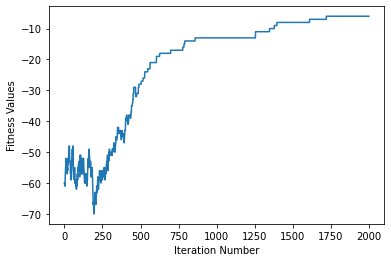

In [59]:
board = read_sudoku_problem('medium-nytimes.txt')
run_simulated_annealing(board)
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

|---------+---------+---------|
| 9  5  7 | 6  1  3 | 2  8  4 |
| 4  8  3 | 2  5  7 | 1  9  6 |
| 6  1  2 | 8  4  7 | 5  3  7 |
|---------+---------+---------|
| 1  7  8 | 3  6  4 | 5  5  2 |
| 5  2  4 | 9  7  1 | 3  6  8 |
| 3  6  9 | 5  2  8 | 7  4  1 |
|---------+---------+---------|
| 8  4  5 | 7  9  2 | 6  1  3 |
| 2  9  1 | 4  3  6 | 8  7  5 |
| 7  3  6 | 1  8  5 | 4  2  9 |
|---------+---------+---------|
@Iter 0 - Best so far: -8.000000
@Iter 13 - Best so far: -6.000000
@Iter 14 - Best so far: -3.000000
@Iter 49 - Best so far: 0.000000
SOLVED!!
|---------+---------+---------|
| 9  5  7 | 6  1  3 | 2  8  4 |
| 4  8  3 | 2  5  7 | 1  9  6 |
| 6  1  2 | 8  4  9 | 5  3  7 |
|---------+---------+---------|
| 1  7  8 | 3  6  4 | 9  5  2 |
| 5  2  4 | 9  7  1 | 3  6  8 |
| 3  6  9 | 5  2  8 | 7  4  1 |
|---------+---------+---------|
| 8  4  5 | 7  9  2 | 6  1  3 |
| 2  9  1 | 4  3  6 | 8  7  5 |
| 7  3  6 | 1  8  5 | 4  2  9 |
|---------+---------+---------|
@Iter 100 cooling to 8.00

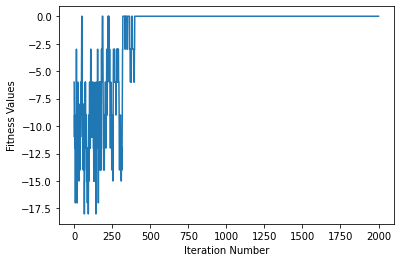

In [60]:
board = read_sudoku_problem('easy_instance.txt')
board.pretty_print()
run_simulated_annealing(board)
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

## 3 B Try Solving Problems and  Reflect on Experience (15 Points)

Try your approach for various number of iterations, cooling schedule and report on the results you got:

  - What was the best solution fitness you obtained?
  - Try changing the number of iterations and cooling schedule, note down what you tried and any observations.
  - Did it try any of the instances? Were any of them successful? Try finding 5 sudoku problems labeled as easy, 5 medium and 5 hard. Let us know how the simulated annealer performed on each class of problems. There is no need to submit any of the problems but describe what these were and describe the performance briefly. If the grader wishes, they may invite you for an "interview" to observe what you tried and your results.
  

YOUR ANSWER HERE

I want to say that I had the best solution fitness when I set initial_temperature = 3, num_trials = 1500, cooling_schedule = (100, 0.4). When I first tried num_trail = 4000, and initial_temperature = 40, I noticed that most of the sudoku were cooling to 0.0 by around 1500 ~ 2000 iteration. To make things more efficient, I tried plugging in different numbers and I ended up getting initial_temperature = 3, num_trials = 1500, cooling_schedule = (100, 0.4) with the lowest score -8. Comparing the results it seems that all 3 difficulties ended up with similar results. 

|---------+---------+---------|
| 7  3  4 | 2  6  9 | 8  3  9 |
| 2  1  5 | 3  7  7 | 9  6  2 |
| 2  9  8 | 1  7  7 | 5  4  3 |
|---------+---------+---------|
| 7  5  1 | 5  3  8 | 2  3  5 |
| 7  2  2 | 7  8  6 | 7  1  5 |
| 3  2  1 | 2  2  7 | 4  9  5 |
|---------+---------+---------|
| 5  8  3 | 7  9  5 | 7  6  4 |
| 7  5  7 | 6  1  8 | 3  2  6 |
| 7  6  1 | 4  3  2 | 1  5  8 |
|---------+---------+---------|
@Iter 0 - Best so far: -58.000000
@Iter 4 - Best so far: -57.000000
@Iter 23 - Best so far: -56.000000
@Iter 24 - Best so far: -54.000000
@Iter 32 - Best so far: -52.000000
@Iter 33 - Best so far: -51.000000
@Iter 100 cooling to 16.000000
@Iter 200 cooling to 6.400000
@Iter 300 cooling to 2.560000
@Iter 330 - Best so far: -50.000000
@Iter 332 - Best so far: -49.000000
@Iter 338 - Best so far: -48.000000
@Iter 345 - Best so far: -47.000000
@Iter 346 - Best so far: -46.000000
@Iter 380 - Best so far: -45.000000
@Iter 382 - Best so far: -44.000000
@Iter 383 - Best so far: -43.0000

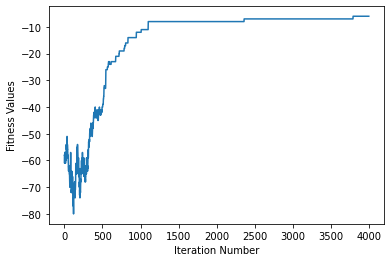

In [61]:
board = read_sudoku_problem('2C_Easy.txt')
board.pretty_print()
run_simulated_annealing(board, initial_temperature = 40, num_trials = 4000, cooling_schedule = (100, 0.4))
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

|---------+---------+---------|
| 5  9  3 | 1  2  2 | 7  2  7 |
| 8  1  4 | 4  3  2 | 9  5  6 |
| 1  1  4 | 6  2  7 | 3  4  2 |
|---------+---------+---------|
| 9  4  1 | 3  1  8 | 4  7  1 |
| 2  9  4 | 9  7  9 | 4  3  9 |
| 1  1  7 | 5  1  4 | 6  3  1 |
|---------+---------+---------|
| 1  3  9 | 8  4  9 | 5  6  6 |
| 9  9  2 | 7  1  9 | 8  3  3 |
| 9  9  1 | 7  5  6 | 2  4  4 |
|---------+---------+---------|
@Iter 0 - Best so far: -74.000000
@Iter 3 - Best so far: -73.000000
@Iter 5 - Best so far: -72.000000
@Iter 19 - Best so far: -71.000000
@Iter 23 - Best so far: -70.000000
@Iter 26 - Best so far: -68.000000
@Iter 46 - Best so far: -67.000000
@Iter 47 - Best so far: -64.000000
@Iter 48 - Best so far: -63.000000
@Iter 52 - Best so far: -61.000000
@Iter 67 - Best so far: -59.000000
@Iter 93 - Best so far: -58.000000
@Iter 100 cooling to 9.000000
@Iter 104 - Best so far: -57.000000
@Iter 151 - Best so far: -55.000000
@Iter 152 - Best so far: -54.000000
@Iter 200 cooling to 2.700000

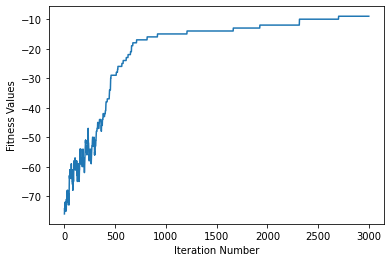

In [63]:
board = read_sudoku_problem('2C_Hard.txt')
board.pretty_print()
run_simulated_annealing(board, initial_temperature = 30, num_trials = 3000, cooling_schedule = (100, 0.3))
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

|---------+---------+---------|
| 4  1  4 | 9  7  7 | 8  4  6 |
| 1  5  3 | 2  7  4 | 5  9  7 |
| 9  1  4 | 8  3  3 | 7  2  7 |
|---------+---------+---------|
| 3  4  7 | 1  6  8 | 2  8  5 |
| 5  6  1 | 4  1  1 | 3  8  1 |
| 2  8  8 | 7  8  5 | 1  7  4 |
|---------+---------+---------|
| 4  8  1 | 6  5  1 | 1  3  2 |
| 1  3  2 | 1  4  9 | 6  4  8 |
| 3  7  6 | 1  3  2 | 9  5  1 |
|---------+---------+---------|
@Iter 0 - Best so far: -55.000000
@Iter 5 - Best so far: -53.000000
@Iter 6 - Best so far: -52.000000
@Iter 29 - Best so far: -51.000000
@Iter 30 - Best so far: -50.000000
@Iter 51 - Best so far: -48.000000
@Iter 100 cooling to 4.000000
@Iter 148 - Best so far: -47.000000
@Iter 149 - Best so far: -45.000000
@Iter 178 - Best so far: -44.000000
@Iter 200 cooling to 0.800000
@Iter 208 - Best so far: -42.000000
@Iter 214 - Best so far: -41.000000
@Iter 215 - Best so far: -40.000000
@Iter 224 - Best so far: -39.000000
@Iter 260 - Best so far: -38.000000
@Iter 261 - Best so far: -35.

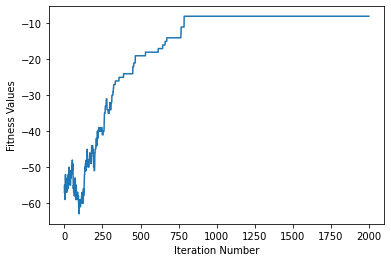

In [62]:
board = read_sudoku_problem('2C_Hard2.txt')
board.pretty_print()
run_simulated_annealing(board, initial_temperature = 20, num_trials = 2000, cooling_schedule = (100, 0.2))
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

|---------+---------+---------|
| 5  1  1 | 9  3  7 | 2  6  3 |
| 2  1  2 | 4  6  1 | 5  2  3 |
| 7  5  3 | 1  1  2 | 8  4  9 |
|---------+---------+---------|
| 6  4  1 | 1  2  9 | 1  5  7 |
| 8  9  2 | 5  7  4 | 4  2  8 |
| 5  5  7 | 4  4  8 | 3  2  5 |
|---------+---------+---------|
| 9  5  5 | 8  8  6 | 9  3  1 |
| 3  8  9 | 7  4  4 | 1  9  9 |
| 1  2  4 | 3  9  5 | 3  8  6 |
|---------+---------+---------|
@Iter 0 - Best so far: -58.000000
@Iter 1 - Best so far: -56.000000
@Iter 2 - Best so far: -55.000000
@Iter 12 - Best so far: -53.000000
@Iter 14 - Best so far: -52.000000
@Iter 15 - Best so far: -51.000000
@Iter 18 - Best so far: -50.000000
@Iter 19 - Best so far: -49.000000
@Iter 20 - Best so far: -47.000000
@Iter 59 - Best so far: -46.000000
@Iter 63 - Best so far: -45.000000
@Iter 100 cooling to 0.900000
@Iter 119 - Best so far: -44.000000
@Iter 123 - Best so far: -43.000000
@Iter 175 - Best so far: -42.000000
@Iter 200 cooling to 0.270000
@Iter 207 - Best so far: -41.00000

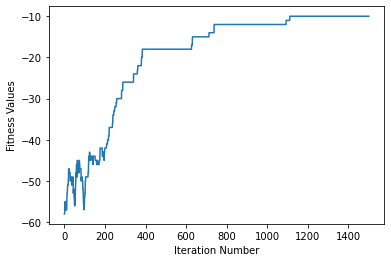

In [64]:
board = read_sudoku_problem('2C_Medium.txt')
board.pretty_print()
run_simulated_annealing(board, initial_temperature = 3, num_trials = 1500, cooling_schedule = (100, 0.3))
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

|---------+---------+---------|
| 2  6  1 | 9  8  7 | 1  1  3 |
| 4  7  7 | 1  6  4 | 5  9  3 |
| 1  6  3 | 1  1  2 | 8  4  9 |
|---------+---------+---------|
| 6  4  1 | 3  2  9 | 3  3  7 |
| 2  9  2 | 5  7  1 | 6  6  8 |
| 2  1  7 | 1  3  8 | 2  6  5 |
|---------+---------+---------|
| 9  6  7 | 2  4  6 | 4  1  2 |
| 3  8  6 | 7  9  4 | 4  1  9 |
| 9  2  4 | 1  3  5 | 9  8  6 |
|---------+---------+---------|
@Iter 0 - Best so far: -60.000000
@Iter 1 - Best so far: -59.000000
@Iter 6 - Best so far: -58.000000
@Iter 10 - Best so far: -56.000000
@Iter 11 - Best so far: -54.000000
@Iter 12 - Best so far: -53.000000
@Iter 22 - Best so far: -52.000000
@Iter 25 - Best so far: -51.000000
@Iter 32 - Best so far: -50.000000
@Iter 33 - Best so far: -49.000000
@Iter 34 - Best so far: -48.000000
@Iter 36 - Best so far: -47.000000
@Iter 38 - Best so far: -46.000000
@Iter 39 - Best so far: -45.000000
@Iter 44 - Best so far: -43.000000
@Iter 100 cooling to 1.200000
@Iter 177 - Best so far: -42.000

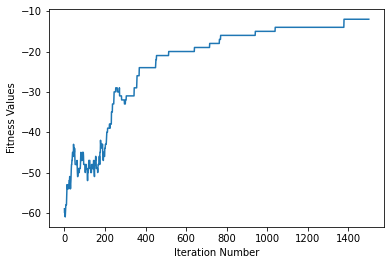

In [65]:
board = read_sudoku_problem('2C_Medium.txt')
board.pretty_print()
run_simulated_annealing(board, initial_temperature = 3, num_trials = 1500, cooling_schedule = (100, 0.4))
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

In [166]:
board = read_sudoku_problem('easy_instance.txt')
board.pretty_print()
run_simulated_annealing(board)
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

|---------+---------+---------|
| 9  5  7 | 6  1  3 | 2  8  4 |
| 4  8  3 | 2  5  7 | 1  9  6 |
| 6  1  2 | 8  4  7 | 5  5  7 |
|---------+---------+---------|
| 1  7  8 | 3  6  4 | 9  5  2 |
| 5  2  4 | 9  7  7 | 3  6  8 |
| 3  6  9 | 5  2  8 | 7  4  1 |
|---------+---------+---------|
| 8  9  5 | 7  9  2 | 6  1  3 |
| 2  9  1 | 4  3  6 | 8  7  5 |
| 7  3  6 | 1  8  5 | 4  2  9 |
|---------+---------+---------|


AttributeError: 'builtin_function_or_method' object has no attribute 'choice'

|---------+---------+---------|
| 9  5  7 | 6  1  3 | 2  8  4 |
| 4  8  3 | 2  5  7 | 1  9  6 |
| 6  1  2 | 8  4  7 | 5  5  7 |
|---------+---------+---------|
| 1  7  8 | 3  6  4 | 9  5  2 |
| 5  2  4 | 9  7  7 | 3  6  8 |
| 3  6  9 | 5  2  8 | 7  4  1 |
|---------+---------+---------|
| 8  9  5 | 7  9  2 | 6  1  3 |
| 2  9  1 | 4  3  6 | 8  7  5 |
| 7  3  6 | 1  8  5 | 4  2  9 |
|---------+---------+---------|
@Iter 0 - Best so far: -27.000000
@Iter 1 - Best so far: -25.000000
@Iter 4 - Best so far: -23.000000
@Iter 72 - Best so far: -21.000000
@Iter 100 cooling to 8.000000
@Iter 200 cooling to 3.200000
@Iter 300 cooling to 1.280000
@Iter 400 cooling to 0.512000
@Iter 500 cooling to 0.204800
@Iter 600 cooling to 0.081920
@Iter 700 cooling to 0.032768
@Iter 800 cooling to 0.013107
@Iter 900 cooling to 0.005243
@Iter 1000 cooling to 0.002097
@Iter 1100 cooling to 0.000839
@Iter 1200 cooling to 0.000336
@Iter 1300 cooling to 0.000134
@Iter 1400 cooling to 0.000054
@Iter 1500 cooling to 

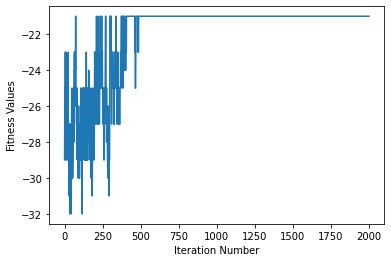

In [49]:
board = read_sudoku_problem('easy_instance.txt')
board.pretty_print()
run_simulated_annealing(board)
print('Output of this cell will be examined by the TA. Make sure that it shows the printout and the final plot.')

## Extra Credit

Implement a genetic algorithm for extra credit opportunity
  - Try different crossover operators on sudoku board. Which ones did you implement?
  - Write a genetic algorithm solver using mutation and crossover operators.
  - Try your solver on various easy, medium and difficult problems.
  - Write a nice report summarizing what you tried, your findings and package your code so that others may learn.
  
Grading is done by interviewing with a TA. This can be submitted up to a week after the assignment is due.
Same rules apply as previous Extra Credit Opportunity. You can skip a spot exam if you are awarded this opportunity.

## That's all folks